In [2]:
#| label: code

#!pip install scikit-learn
#!pip install tensorflow 
#!pip install yfinance
#!pip install plotly
#!pip install statsmodels
#!pip install IPython
#!pip install matplotlib
#!pip install seaborn
#!pip install jupyter
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import yfinance as yf
import plotly.express as px
import statsmodels.api as sm 
from IPython.display import IFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.layers import Dense, SimpleRNN, LSTM, GRU

In [3]:
#|label: download-stock

# Pfizer
pfe = yf.download("PFE", '2019-01-01','2024-04-01')

# Teva
teva = yf.download("TEVA", '2019-01-01','2024-04-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
#|label: clean-stock

# Clean PFE
pfe = pfe.reset_index()
pfe = pfe.rename(columns={'Date':'t', 'Adj Close':'y'})
pfe = pfe[['t', 'y']]
t_pfe = np.array([*range(0,pfe.shape[0])])
x_pfe = np.array(pfe['y']).reshape(t_pfe.shape[0],1)
feature_columns_pfe = [0]
target_columns_pfe = [0]

# Clean TEVA
teva = teva.reset_index()
teva = teva.rename(columns={'Date':'t', 'Adj Close':'y'})
teva = teva[['t', 'y']]
t_teva = np.array([*range(0,teva.shape[0])])
x_teva = np.array(teva['y']).reshape(t_teva.shape[0],1)
feature_columns_teva = [0]
target_columns_teva = [0]

# 1. Original Data

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1319,) (1319, 1)


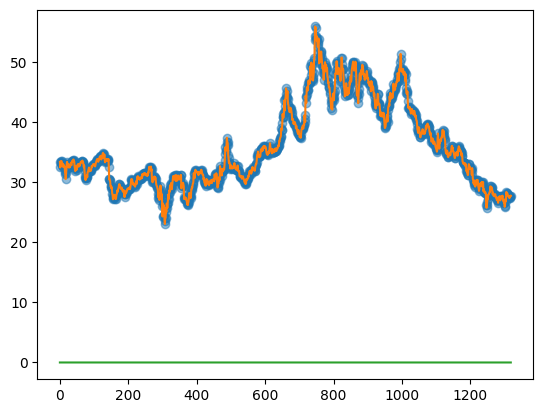

In [7]:
#| label: plot-original-pfe
#| fig-cap: Original Data of PFE Stock

print(type(t_pfe), type(x_pfe))
print(t_pfe.shape, x_pfe.shape)

fig, ax = plt.subplots()
for i in range(0,x_pfe.shape[1]):
    ax.plot(t_pfe, x_pfe[:,i],'o',alpha = 0.5)
    ax.plot(t_pfe, x_pfe[:,i],"-")
ax.plot(t_pfe, 0*x_pfe[:,0],"-")
plt.show()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1319,) (1319, 1)


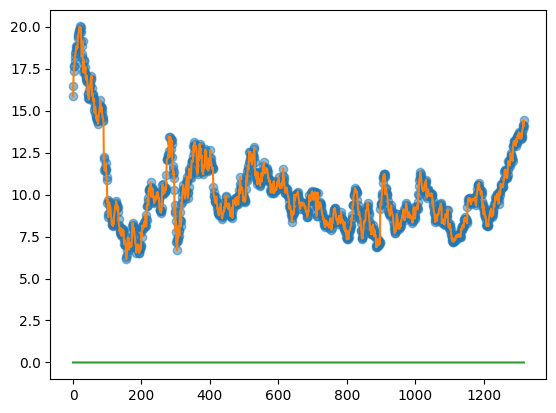

In [6]:
#|label: plot-original-teva
#| fig-cap: Original Data of TEVA Stock

# Plot TEVA
print(type(t_teva), type(x_teva))
print(t_teva.shape, x_teva.shape)
fig, ax = plt.subplots()
for i in range(0,x_teva.shape[1]):
    ax.plot(t_teva, x_teva[:,i],'o',alpha = 0.5)
    ax.plot(t_teva, x_teva[:,i],"-")
ax.plot(t_teva, 0*x_teva[:,0],"-") 
plt.show()

# 2. Fitting Neural Networks and Forecast

## 2.1 Data Preprossing

### Data Normalization

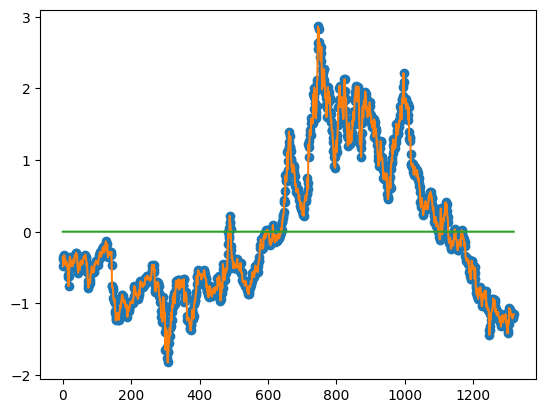

In [15]:
#|label: normalization-pfe
#|fig-cap: Normalized PFE Stock


## Pfizer
#print(np.mean(x_pfe,axis=0).shape,np.std(x_pfe,axis=0).shape)
x_pfe=(x_pfe-np.mean(x_pfe,axis=0))/np.std(x_pfe,axis=0)
#print(x_pfe.shape)
fig, ax = plt.subplots()
for i in range(0,x_pfe.shape[1]):
    ax.plot(t_pfe, x_pfe[:,i],'o')
    ax.plot(t_pfe, x_pfe[:,i],"-")
ax.plot(t_pfe, 0*x_pfe[:,0],"-")
plt.show()

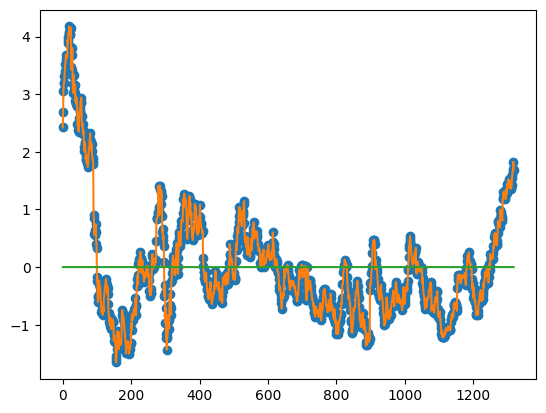

In [13]:
#| label: normalization-teva
#| fig-cap: Normalized TEVA Stock

## TEVA
#print(np.mean(x_teva,axis=0).shape,np.std(x_teva,axis=0).shape)
x_teva=(x_teva-np.mean(x_teva,axis=0))/np.std(x_teva,axis=0)
#print(x_teva.shape)
fig, ax = plt.subplots()
for i in range(0,x_teva.shape[1]):
    ax.plot(t_teva, x_teva[:,i],'o')
    ax.plot(t_teva, x_teva[:,i],"-")
ax.plot(t_teva, 0*x_teva[:,0],"-")
plt.show()

### Data Splitting

### Mini-Batching

## 2.2 RNN

## 2.3 GRU

## 2.4 LSTM